In [1]:
# Initial setup
import os
import torch
from select import select

os.environ["POLARS_UNKNOWN_EXTENSION_TYPE_BEHAVIOR"] = "load_as_storage"
from dotenv import load_dotenv
load_dotenv()
import polars as pl
%load_ext cuml.accel
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import cupy as cp
db_eng = "adbc"
db_uri = os.getenv("DB_URI")
torch.cuda.set_device(0)


In [9]:
# Getting relevant latency data
df_clustered = pl.read_parquet("data/characteristics_clustered.parquet")
def get_trend_data(df, cluster_id, label="default"):
    ips = (df.filter(pl.col("cluster") == cluster_id)
        .select("ip_addr")
        .to_series()
        .to_list()
        )
    ip_list_str = ", ".join([f"('{ip}'::cidr)" for ip in ips])
    trend_query = f"""
        WITH target_ips(ip_addr) AS(
            VALUES {ip_list_str}
        )
        SELECT
            DATE_TRUNC('day', ping_date) as ds,
            AVG(ping_rttavg) as y
        FROM public.ping
        INNER JOIN target_ips USING (ip_addr)
        WHERE ping_ploss < 100
            AND ping_ploss >= 0
            AND ping_date >= '2009-01-01'
            AND ping_rttavg < 20000
        GROUP BY ds
        ORDER BY ds
    """
    df_trend = pl.read_database_uri(query=trend_query, uri=db_uri, engine=db_eng)
    df_trend.write_parquet(f"data/trend_cluster_{label}_{cluster_id}.parquet")
    print(f"Cluster {cluster_id} for {label} done")
    return df_trend

In [7]:
df = pl.read_parquet("data/characteristics_clustered.parquet")
profile = (
    df.group_by("cluster")
    .agg([
        pl.col("mean_rtt").mean().alias("avg_latency"),
        pl.col("jitter").mean().alias("avg_jitter"),
        pl.col("mean_loss").mean().alias("avg_packet_loss"),
        pl.len().alias("ip_count")
    ]).sort("avg_latency")
)
print(profile)

shape: (7, 5)
┌─────────┬─────────────┬─────────────┬─────────────────┬──────────┐
│ cluster ┆ avg_latency ┆ avg_jitter  ┆ avg_packet_loss ┆ ip_count │
│ ---     ┆ ---         ┆ ---         ┆ ---             ┆ ---      │
│ i32     ┆ f64         ┆ f64         ┆ f64             ┆ u32      │
╞═════════╪═════════════╪═════════════╪═════════════════╪══════════╡
│ 0       ┆ 51.224842   ┆ 19.376774   ┆ 0.785795        ┆ 95436    │
│ 6       ┆ 88.602936   ┆ 28.435389   ┆ 11.097186       ┆ 29221    │
│ 5       ┆ 105.928697  ┆ 38.429109   ┆ 38.399315       ┆ 1976     │
│ 4       ┆ 234.608993  ┆ 50.459988   ┆ 2.050385        ┆ 58046    │
│ 2       ┆ 241.121758  ┆ 385.857034  ┆ 2.865826        ┆ 6804     │
│ 1       ┆ 492.068696  ┆ 1135.269626 ┆ 5.772859        ┆ 1166     │
│ 3       ┆ 1943.687038 ┆ 2441.414563 ┆ 17.231956       ┆ 98       │
└─────────┴─────────────┴─────────────┴─────────────────┴──────────┘


In [ ]:
# Downloading trend data
for i in range(profile.height):
    get_trend_data(df, i, label="kmeans")

In [40]:
# NeuralProphet
import neuralprophet
import matplotlib.pyplot as plt
import pandas as pd

def train_and_save_neural_prophet_model(df, model_name, freq="D", normalize="off"):
    pdf = df.to_pandas()
    pdf["ds"] = pd.to_datetime(pdf["ds"])
    pdf["y"] = pd.to_numeric(pdf["y"])

    model = neuralprophet.NeuralProphet(
        weekly_seasonality=False,
        daily_seasonality=False,
        yearly_seasonality=True,
        normalize=normalize,
        trainer_config={"accelerator": "cuda", "devices": 1, "precision": "16-mixed"},
        learning_rate=0.01
    )

    print(f"Training model {model_name}")
    model.fit(pdf, freq=freq, batch_size=64)

    os.makedirs("models", exist_ok=True)
    save_path = f"models/{model_name}.np"
    neuralprophet.save(model, save_path)
    print(f"Model saved to {save_path}")

    return model

In [42]:
import neuralprophet
def visualize_forecast_neuralprophet(df, model_name, title, num_periods):
    save_path = f"models/{model_name}.np"
    if not os.path.exists(save_path):
        print(f"model file {save_path} not found")
        return
    print(f"Loading model from {save_path}")
    model = torch.load(save_path, weights_only=False)

    if hasattr(model, "restore_trainer"):
        model.restore_trainer(accelerator="cuda")

    pdf = df.to_pandas()
    pdf["ds"] = pd.to_datetime(pdf["ds"])
    pdf["y"] = pd.to_numeric(pdf["y"])

    future = model.make_future_dataframe(df=pdf, periods=num_periods, n_historic_predictions=True)
    forecast = model.predict(future)

    plt.figure(figsize=(12, 6))
    plt.scatter(pdf['ds'], pdf['y'], color='black', s=10, alpha=0.3, label='Actual Data')
    plt.plot(forecast['ds'], forecast['yhat1'], label='Model Fit', color='blue', alpha=0.6)
    forecast_period = forecast.tail(num_periods)
    plt.plot(forecast_period['ds'], forecast_period['yhat1'], color='red', linewidth=2, label='Future Prediction')

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Latency (ms)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

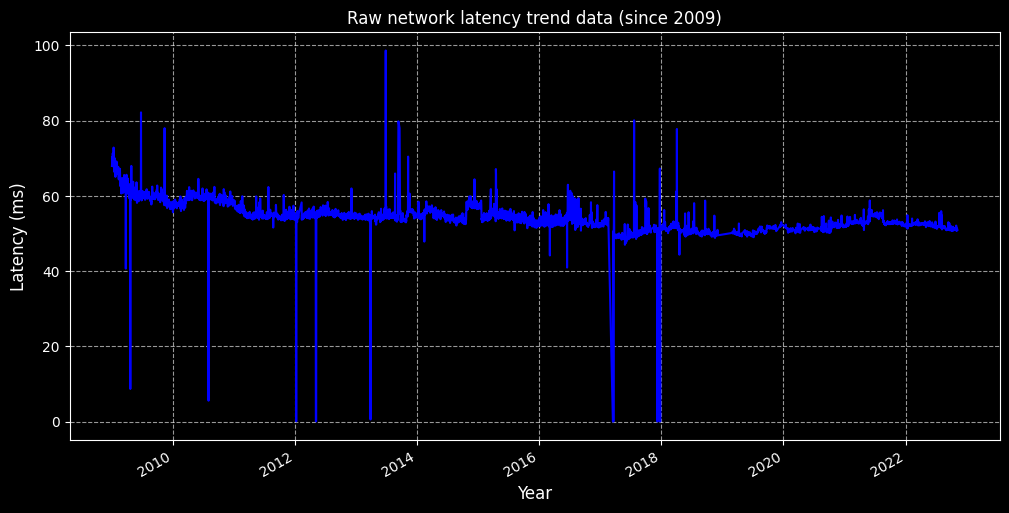

In [4]:
# Visualizing raw network latency trend data
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet").with_columns(pl.from_epoch("ds", time_unit="ns"))
plt.figure(figsize=(12, 6))
plt.plot(core_df["ds"], core_df["y"], label="Latency (ms)", color="blue", linewidth=1.5)
plt.title("Raw network latency trend data (since 2009)")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Latency (ms)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gcf().autofmt_xdate()

plt.show()

In [43]:
# Training neuralprophet, no normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_and_save_neural_prophet_model(core_df, "kmeans_core", normalize="off")

INFO - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view

Training model kmeans_core


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core.np


INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Loading model from models/kmeans_core.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


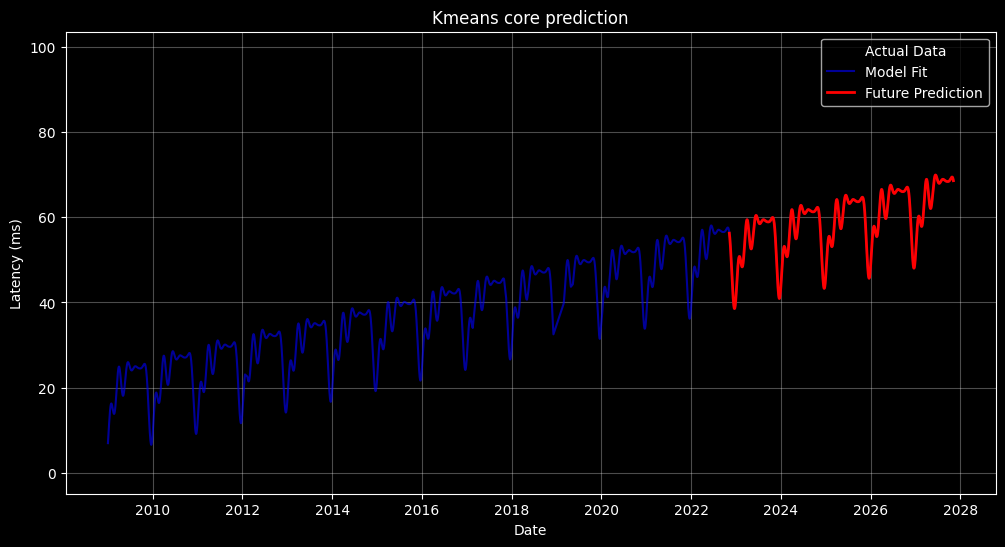

In [44]:
visualize_forecast_neuralprophet(core_df, "kmeans_core", "Kmeans core prediction", num_periods=(5*365))

In [45]:
# Training NeuralProphet with soft normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_and_save_neural_prophet_model(core_df, "kmeans_core_soft", normalize="soft")

INFO - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view

Training model kmeans_core_soft


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core_soft.np


INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Loading model from models/kmeans_core_soft.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


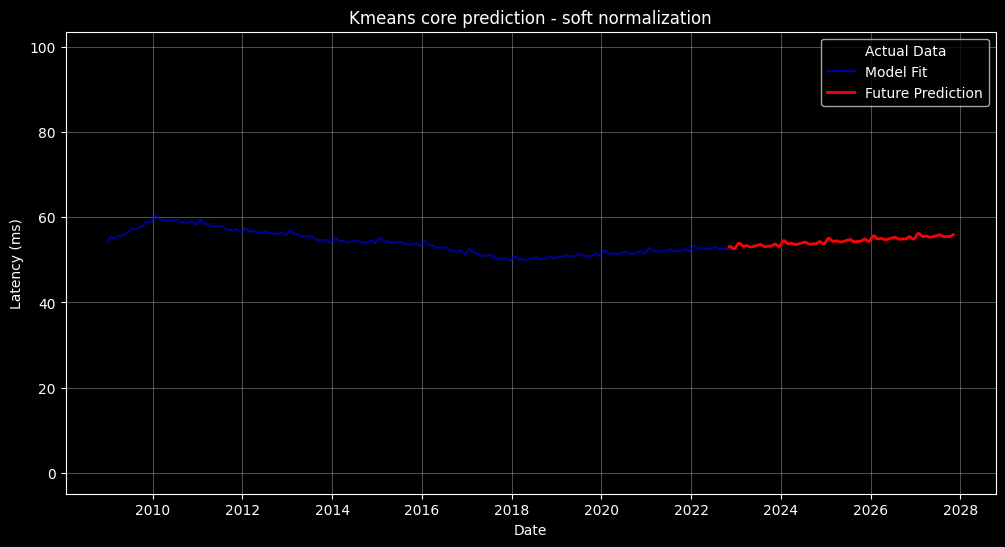

In [46]:
visualize_forecast_neuralprophet(core_df, "kmeans_core_soft", "Kmeans core prediction - soft normalization", num_periods=(5*365))

In [51]:
# Training NeuralProphet with minmax normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_and_save_neural_prophet_model(core_df, "kmeans_core_minmax", normalize="minmax")

INFO - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view

Training model kmeans_core_minmax


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core_minmax.np


INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Loading model from models/kmeans_core_minmax.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


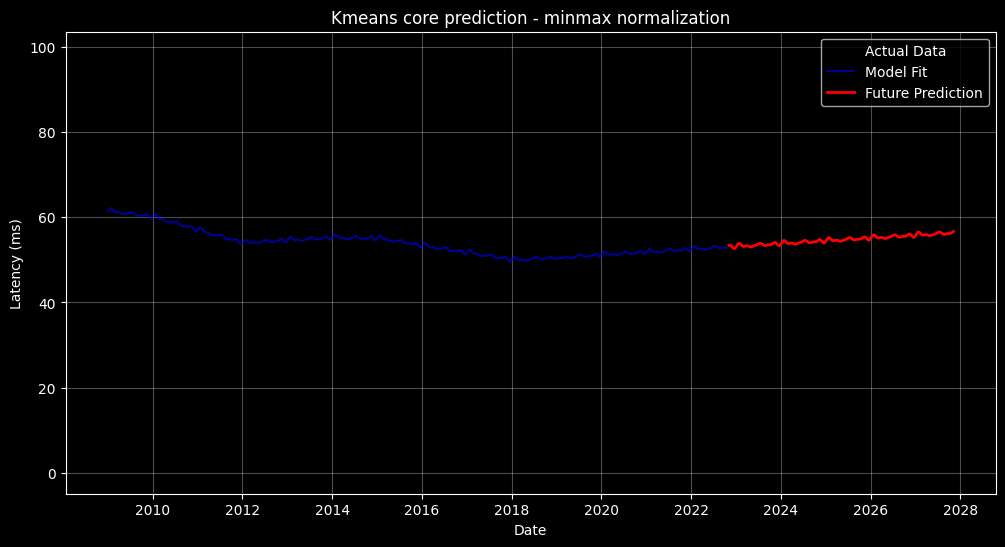

In [52]:
visualize_forecast_neuralprophet(core_df, "kmeans_core_minmax", "Kmeans core prediction - minmax normalization", num_periods=(5*365))

In [53]:
# Training NeuralProphet with standardize normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_and_save_neural_prophet_model(core_df, "kmeans_core_standardize", normalize="standardize")

INFO - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view

Training model kmeans_core_standardize


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core_standardize.np


INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Loading model from models/kmeans_core_standardize.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


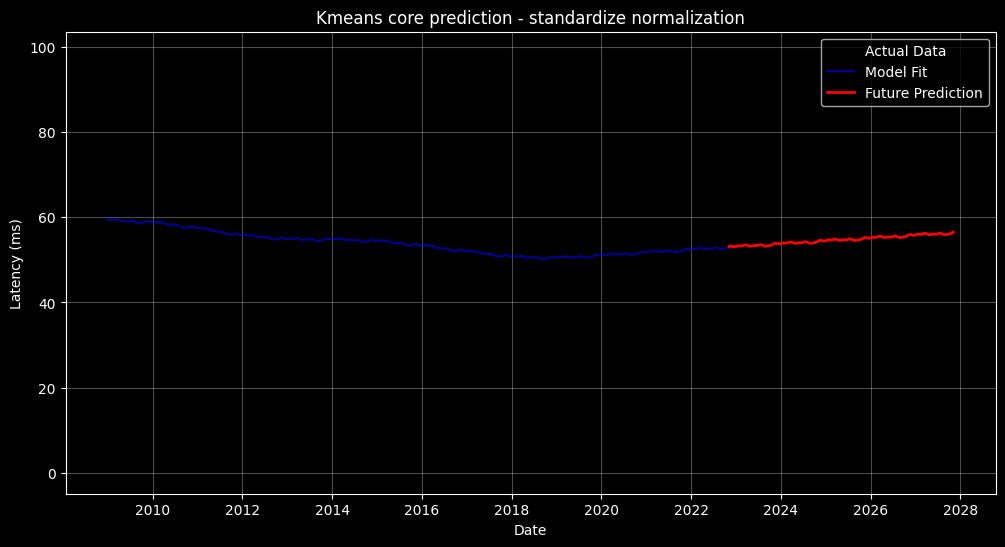

In [54]:
visualize_forecast_neuralprophet(core_df, "kmeans_core_standardize", "Kmeans core prediction - standardize normalization", num_periods=(5*365))

In [57]:
# Model training with validation
def train_validate_and_save_neural_prophet_model(df, model_name, freq="D", normalize="off", learning_rate=0.01):
    pdf = df.to_pandas()
    pdf["ds"] = pd.to_datetime(pdf["ds"])
    pdf["y"] = pd.to_numeric(pdf["y"])

    model = neuralprophet.NeuralProphet(
        weekly_seasonality=False,
        daily_seasonality=False,
        yearly_seasonality=True,
        normalize=normalize,
        trainer_config={"accelerator": "cuda", "devices": 1, "precision": "16-mixed"},
        loss_func="Huber",
        learning_rate=learning_rate
    )

    train_df, validation_df = model.split_df(pdf, freq=freq, valid_p=0.25)

    print(f"Training model {model_name}")
    metrics = model.fit(train_df, validation_df=validation_df, freq=freq, batch_size=64)
    metrics.to_csv(f"data/neuralprophet_model_{model_name}.csv")

    os.makedirs("models", exist_ok=True)
    save_path = f"models/{model_name}.np"
    neuralprophet.save(model, save_path)
    print(f"Model saved to {save_path}")

    return metrics.tail(1)

In [58]:
# Training neuralprophet, no normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_validate_and_save_neural_prophet_model(core_df, "kmeans_core", normalize="off")

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
W

Training model kmeans_core


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core.np


,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
79,5.932165,6.380629,5.784088,0.0,79,15.044086,0.0,23.168631,26.310736,15.069934,0.0


INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Loading model from models/kmeans_core.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


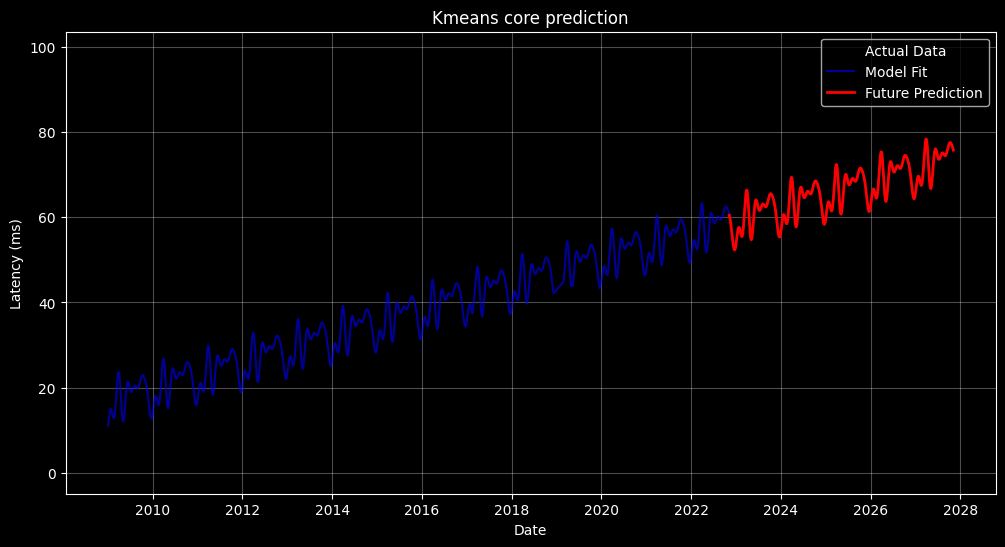

In [59]:
visualize_forecast_neuralprophet(core_df, "kmeans_core", "Kmeans core prediction", num_periods=(5*365))

In [61]:
# Training neuralprophet, soft normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_validate_and_save_neural_prophet_model(core_df, "kmeans_core_soft", normalize="soft")

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
W

Training model kmeans_core_soft


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core_soft.np


,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
79,6.224827,6.520731,0.019354,0.0,79,0.005471,0.0,1.882362,4.080096,0.005406,0.0


WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
W

Training model kmeans_core


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Model saved to models/kmeans_core.np
Loading model from models/kmeans_core_soft.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


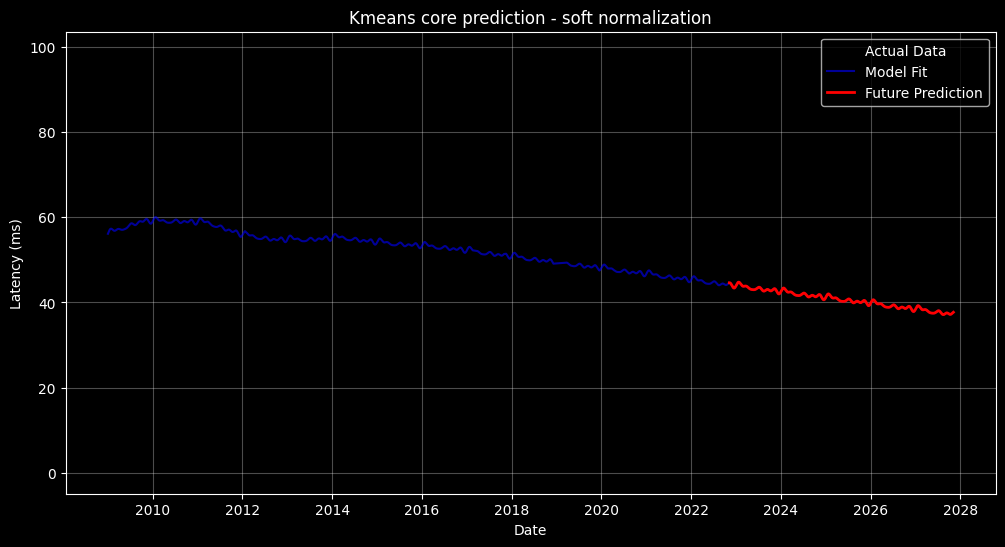

In [62]:
train_validate_and_save_neural_prophet_model(core_df, "kmeans_core", normalize="off")
visualize_forecast_neuralprophet(core_df, "kmeans_core_soft", "Kmeans core prediction - soft normalization", num_periods=(5 * 365))

In [63]:
# Training NeuralProphet with minmax normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_validate_and_save_neural_prophet_model(core_df, "kmeans_core_minmax", normalize="minmax")

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
W

Training model kmeans_core_minmax


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core_minmax.np


,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
79,5.249465,5.54269,0.005294,0.0,79,0.002362,0.0,1.519804,3.575576,0.002343,0.0


WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
W

Training model kmeans_core


INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.755% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 86400ms
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Model saved to models/kmeans_core.np
Loading model from models/kmeans_core_minmax.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


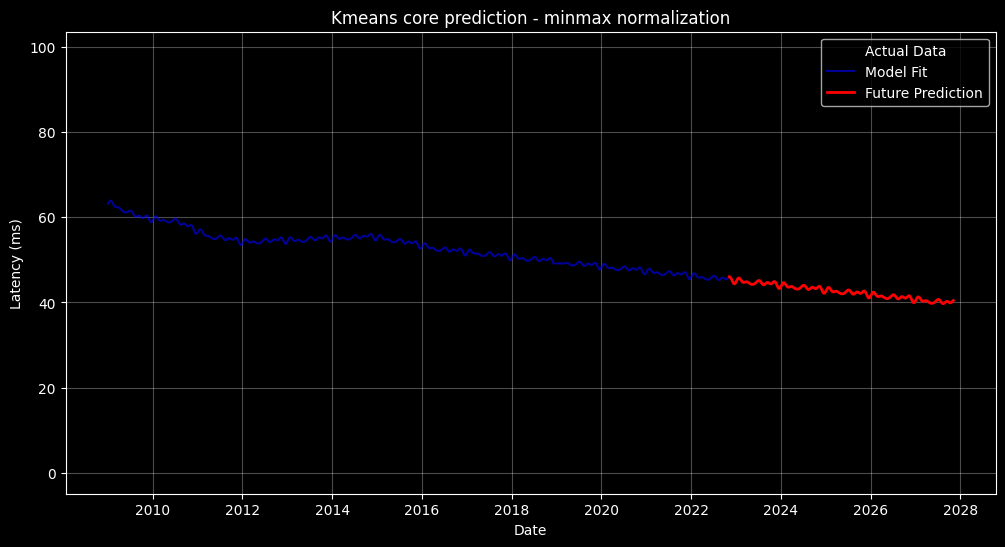

In [64]:
train_validate_and_save_neural_prophet_model(core_df, "kmeans_core", normalize="off")
visualize_forecast_neuralprophet(core_df, "kmeans_core_minmax", "Kmeans core prediction - minmax normalization", num_periods=(5 * 365))

In [65]:
# Training NeuralProphet with standardize normalization
core_df = pl.read_parquet("data/trend_cluster_kmeans_0.parquet")
train_validate_and_save_neural_prophet_model(core_df, "kmeans_core_standardize", normalize="standardize")

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
W

Training model kmeans_core_standardize


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved to models/kmeans_core_standardize.np


,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
79,5.296919,5.582223,0.79761,0.0,79,0.129354,0.0,1.529277,3.584803,0.128961,0.0


WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
W

Training model kmeans_core


WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:463: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.755% of the data.
W

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.utils.configure_trainer) - Using accelerator cuda with 1 device(s).


Model saved to models/kmeans_core.np
Loading model from models/kmeans_core_minmax.np


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 86400ms corresponds to 98.811% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/crelip/PycharmProjects/ML_Ping/.venv/lib/python3.13/site-packages/neuralprophet/df_utils.py:1149: FutureWarning: Series.view is deprecated and will be re

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


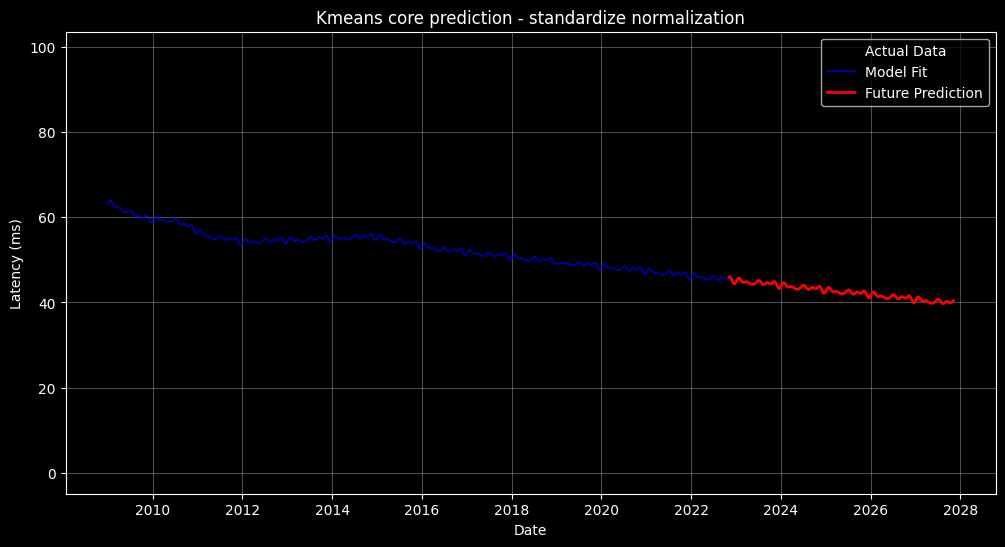

In [66]:
train_validate_and_save_neural_prophet_model(core_df, "kmeans_core", normalize="off")
visualize_forecast_neuralprophet(core_df, "kmeans_core_minmax", "Kmeans core prediction - standardize normalization", num_periods=(5 * 365))